## **Notebook 11-02**: Introduction to Multi-Armed Bandits
### Demo:

In this notebook, we will explore **multi-armed bandits**, a simplified Reinforcement Learning (RL) problem. A *bandit problem* has no notion of *state* transitions like a full MDP. Each time you choose ("pull") an arm, you get a reward from that arm's distribution. The environment does not change states—only your knowledge about the arm payoff does.

To illustrate this, we will:
1. define a small multi-armed bandit environment
2. write a random agent that just picks arms randomly
3. write an epsilon-greedy agent that balances exploration and exploitation.
4. Compare and visualize their performance.

In [34]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

### Gymnasium for Bandits
While Gymnasium primarily provides environments for full RL tasks (with states, transitions, etc.), we can easily create a minimal bandit environment ourselves.

Below, we define a simple custom environment called `SimpleBanditEnv` that:
- Has a discrete action space: `action_space = gym.spaces.Discrete(K)`.
- Has a single "state" (we'll just use a dummy observation or an integer 0, because bandits are stateless in the usual sense).
- Each arm \(i\) has a fixed reward probability distribution. For simplicity, let's assume each arm yields a reward from a Bernoulli distribution with some probability \(p_i\).

The typical elements will be as follows:
1. **Action space**: `gym.spaces.Discrete(K)` for \(K\) arms.
2. **Observation space**: We'll just return a dummy observation (0) or a single-element array, since there's no real state progression.
3. **Reset**: Resets nothing beyond any internal counters. Returns the dummy observation.
4. **Step(action)**: Samples from the chosen arm's Bernoulli distribution, returns the reward, sets `done=True` after each step (bandit tasks can be considered one-step episodes), no real 'next state'.

In [35]:
class SimpleBanditEnv(gym.Env):
    """
    A simple K-armed bandit environment.
    Reward distribution is Bernoulli with a fixed probability for each arm.
    """
    def __init__(self, prob_list=None):
        super().__init__()
        if prob_list is None:
            # default: 4 arms
            prob_list = [0.1, 0.3, 0.6, 0.8]
        self.prob_list = prob_list
        self.num_arms = len(prob_list)

        # Define action and observation spaces
        self.action_space = spaces.Discrete(self.num_arms)
        # We'll have a single integer observation, always 0. Or we can do Discrete(1).
        self.observation_space = spaces.Discrete(1)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # no internal state to reset, just return a dummy observation
        return 0, {}

    def step(self, action):
        # Sample reward from Bernoulli distribution
        prob = self.prob_list[action]
        reward = np.random.binomial(n=1, p=prob)

        # For a bandit, we can consider each pull as an entire episode
        done = True  # end the episode immediately
        truncated = False
        info = {"prob": prob}

        return 0, reward, done, truncated, info

Reminder:
Beyond are given cells, provide to the students
___
Below is the exercise

In [36]:

env = SimpleBanditEnv()

for _ in range(5):
    action = env.action_space.sample()
    info = env.step(action)
    print(f"State: {info[0]} action: {action} reward: {info[1]} done: {info[2]} info: {info[4]}")
    env.reset()



State: 0 action: 3 reward: 1 done: True info: {'prob': 0.8}
State: 0 action: 0 reward: 0 done: True info: {'prob': 0.1}
State: 0 action: 3 reward: 1 done: True info: {'prob': 0.8}
State: 0 action: 2 reward: 1 done: True info: {'prob': 0.6}
State: 0 action: 2 reward: 1 done: True info: {'prob': 0.6}


In [37]:
def random_agent(num_steps, print_results=False):
    total_revard = 0
    
    for _ in range(num_steps):
        action = env.action_space.sample()
        info = env.step(action)
        total_revard += info[1]
        
        if print_results:
            print(f"State: {info[0]} action: {action} reward: {info[1]} done: {info[2]} info: {info[4]}")
            
        env.reset()
        
    return total_revard / num_steps



In [38]:
print(random_agent(1000))

0.444


In [39]:
env = SimpleBanditEnv()
def action_revard(action):
    pass

def greedy_agent(num_steps, eps=0.1, print_results = False):
    
    total_revard = 0
    Q = np.zeros(env.num_arms)
    N = np.zeros(env.num_arms)
    
    for _ in range(num_steps):
        random_number = np.random.uniform(0, 1)
        if random_number <= eps:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q)
            
        N[action] += 1
        
        info = env.step(action)
        total_revard += info[1]
        Q[action] += (1/(N[action]) * (info[1] - Q[action]))
        
        if print_results:
            print(f"State: {info[0]} action: {action} reward: {info[1]} done: {info[2]} info: {info[4]}")
            
        
    return total_revard / num_steps, Q
    
    

In [40]:
greedy_agent(1000)

(0.773, array([0.17241379, 0.41666667, 0.7       , 0.80370774]))

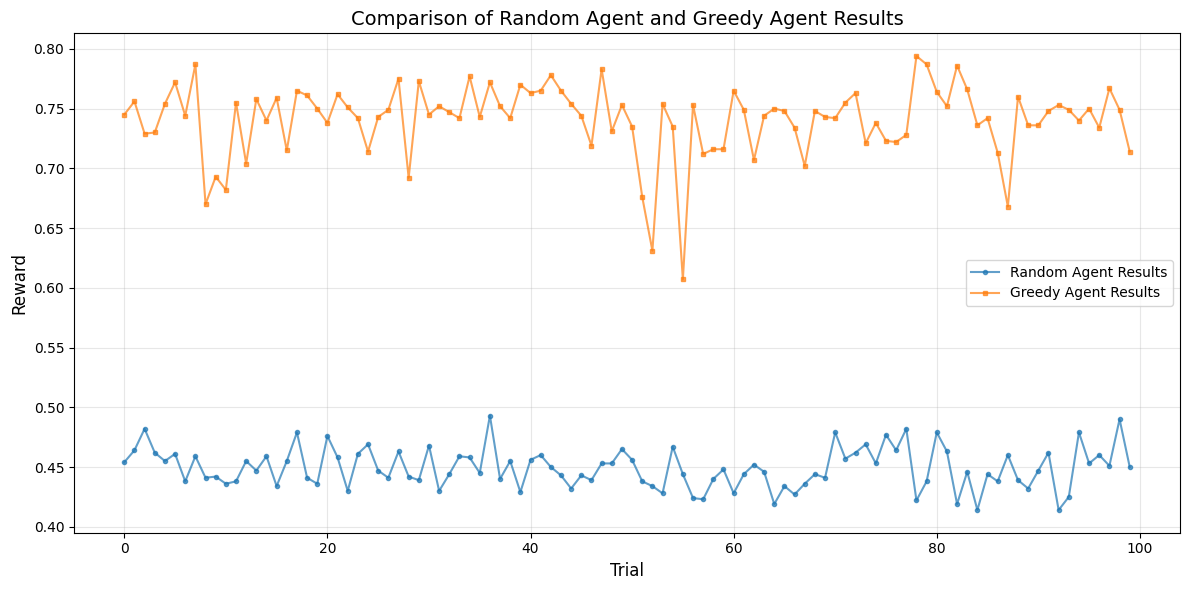

In [41]:
random_agent_results = np.array([random_agent(1000) for _ in range(100)])
greedy_agent_results = np.array([greedy_agent(1000)[0] for _ in range(100)])


plt.figure(figsize=(12, 6))
plt.plot(random_agent_results, label='Random Agent Results', linestyle='-', marker='o', markersize=3, alpha=0.7)
plt.plot(greedy_agent_results, label='Greedy Agent Results', linestyle='-', marker='s', markersize=3, alpha=0.7)
plt.title("Comparison of Random Agent and Greedy Agent Results", fontsize=14)
plt.xlabel("Trial", fontsize=12)
plt.ylabel("Reward", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


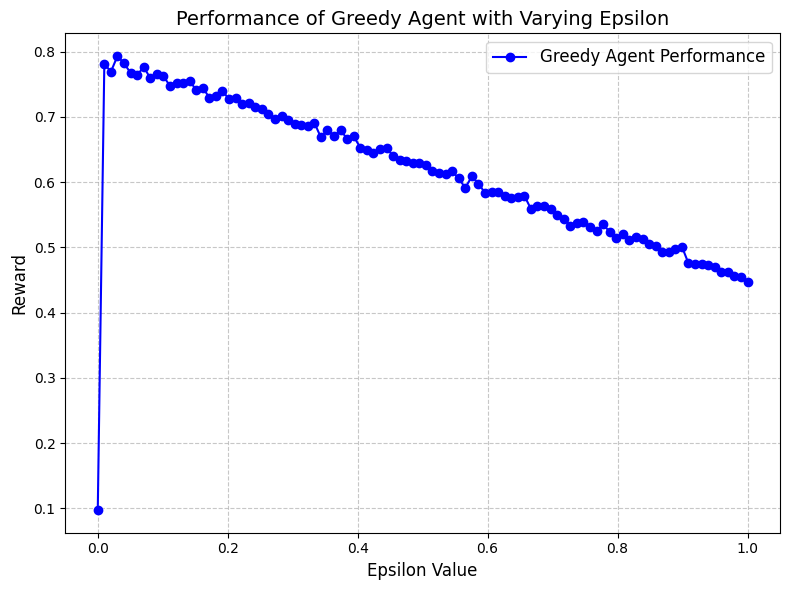

In [42]:
eps_range = np.linspace(0, 1, 100)
eps_res_list = []

for eps in eps_range:
    eps_res_list.append(greedy_agent(10000, eps = eps)[0])
    
plt.figure(figsize=(8, 6))
plt.plot(eps_range, eps_res_list, label='Greedy Agent Performance', color='blue', linestyle='-', marker='o')

plt.title('Performance of Greedy Agent with Varying Epsilon', fontsize=14)
plt.xlabel('Epsilon Value', fontsize=12)
plt.ylabel('Reward', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

